In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Auxiliary functions

In [2]:
def percentage_above_bar_relative_to_xgroup(ax, fontsize=10):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=fontsize, ha='center', va='bottom')
            
            
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plt_confusion_matrix(clf, X_test, y_test):
    cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=clf.classes_)
    disp.plot()

# Read the dataset

From https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset. The features are:

1. age
2. sex (categorical)
3. chest pain type (4 values) (categorical)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

Target variable is `target` where 1 stands for heart failure.

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
len(df)

1025

# Pre-processing

##### What datatype for each column?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


##### Do we have null cells?

In [6]:
(df.isna().sum(axis=1) > 0).sum()

0

# Exploratory data analysis

In [7]:
Categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Ordinal_vars = df.drop(Categorical_vars, axis=1).drop('target', axis=1).columns.to_list()

Categorical_vars_w_target = ['sex', 'cp', 'fbs', 'restecg','exang', 'slope', 'ca', 'thal', 'target']
Ordinal_vars_w_target = df.drop(Categorical_vars, axis=1).columns.to_list()

##### Imbalanced dataset?

In [8]:
df['target'].value_counts()

1    526
0    499
Name: target, dtype: int64

We use Recall as the model evaluation metric so that we avoid false negatives (patient had heart failure but the model predicts that the person did not).

##### Descriptive statistics of the overall dataset

In [9]:
df.drop(Categorical_vars_w_target, axis=1).describe()

,age,trestbps,chol,thalach,oldpeak
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000
mean,54.434146,131.611707,246.00000,149.114146,1.071512
std,9.072290,17.516718,51.59251,23.005724,1.175053
min,29.000000,94.000000,126.00000,71.000000,0.000000
25%,48.000000,120.000000,211.00000,132.000000,0.000000
50%,56.000000,130.000000,240.00000,152.000000,0.800000
75%,61.000000,140.000000,275.00000,166.000000,1.800000
max,77.000000,200.000000,564.00000,202.000000,6.200000


##### Descriptive statistics of those without diabetes

In [10]:
df[df['target']==0].drop(Categorical_vars_w_target, axis=1).describe()

,age,trestbps,chol,thalach,oldpeak
count,499.000000,499.000000,499.000000,499.000000,499.000000
mean,56.569138,134.106212,251.292585,139.130261,1.600200
std,7.908153,18.576736,49.558924,22.565235,1.290956
min,35.000000,100.000000,131.000000,71.000000,0.000000
25%,52.000000,120.000000,217.000000,125.000000,0.600000
50%,58.000000,130.000000,249.000000,142.000000,1.400000
75%,62.000000,144.000000,284.000000,156.000000,2.500000
max,77.000000,200.000000,409.000000,195.000000,6.200000


##### Descriptive statistics of those with diabetes

In [11]:
df[df['target']==1].drop(Categorical_vars_w_target, axis=1).describe()

,age,trestbps,chol,thalach,oldpeak
count,526.000000,526.000000,526.000000,526.000000,526.000000
mean,52.408745,129.245247,240.979087,158.585551,0.569962
std,9.631804,16.112188,53.010345,19.096928,0.771079
min,29.000000,94.000000,126.000000,96.000000,0.000000
25%,44.000000,120.000000,208.000000,149.000000,0.000000
50%,52.000000,130.000000,234.000000,161.500000,0.200000
75%,59.000000,140.000000,265.750000,172.000000,1.000000
max,76.000000,180.000000,564.000000,202.000000,4.200000


##### Pair plot of the features

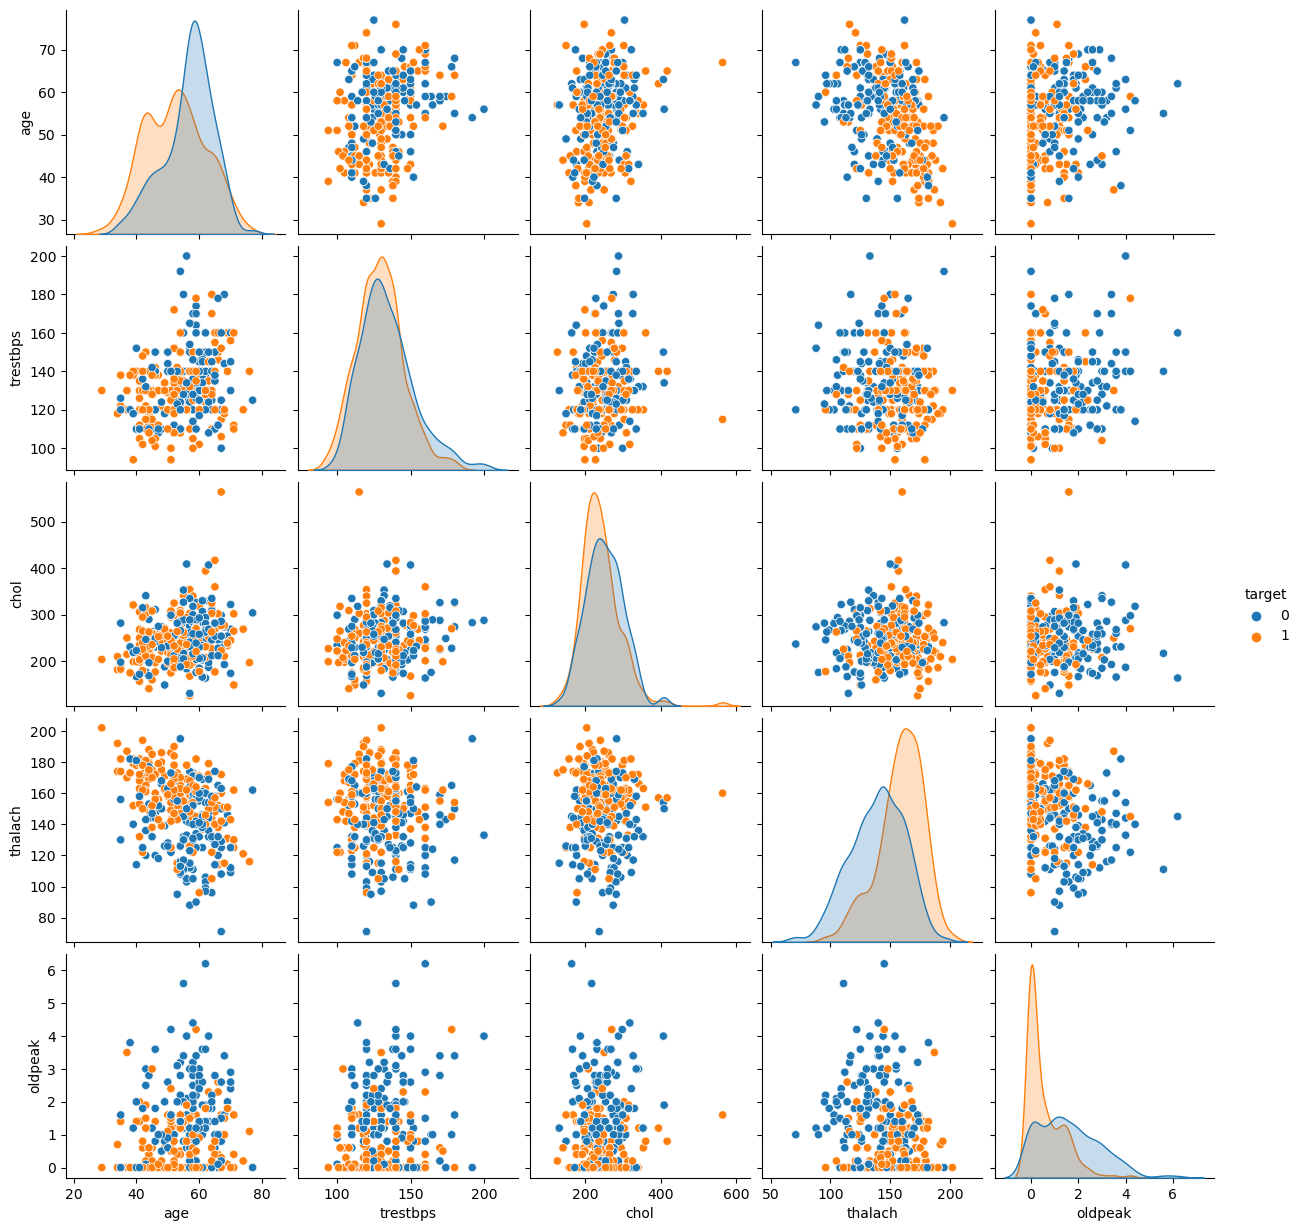

In [12]:
#plt.figure(figsize=(20,20))
sns.pairplot(data=df[Ordinal_vars_w_target], hue="target")

##### Are there features that are correlated to each other?

In [13]:
corr_matrix = df[Ordinal_vars].corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\tonba\AppData\Local\Temp\ipykernel_18352\2244935370.py:6: FutureWarning: `null_color` is deprecated: use `color` instead
  (corr_matrix
C:\Users\tonba\AppData\Local\Temp\ipykernel_18352\2244935370.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2))


,age,trestbps,chol,thalach,oldpeak
age,nan,nan,nan,nan,nan
trestbps,0.27,nan,nan,nan,nan
chol,0.22,0.13,nan,nan,nan
thalach,-0.39,-0.04,-0.02,nan,nan
oldpeak,0.21,0.19,0.06,-0.35,nan


The features don't seem to have very strong correlations.

##### Which features are correlated to the target variable?

(-0.5, 0.5)

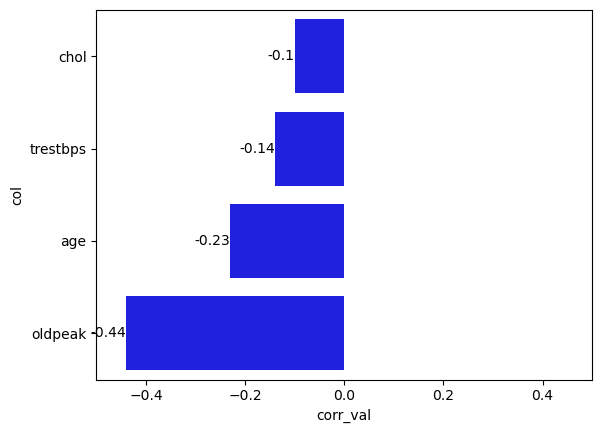

In [14]:
df_correlation = pd.DataFrame(df.corr()['target'][Ordinal_vars].sort_values(ascending=False)[1:]).reset_index()
df_correlation.rename(columns = {'index':'col', 'target':'corr_val'}, inplace = True)
df_correlation['corr_val'] = df_correlation['corr_val'].round(2)
df_correlation.sort_values('corr_val', ascending=False)

#plt.figure()
ax = sns.barplot(data=df_correlation, x="corr_val", y="col", color="b")
ax.bar_label(ax.containers[0])
plt.xlim(-.5,.5)

Glucose for obvious reasons is the highest indicator.

##### Counts for the categorical variables

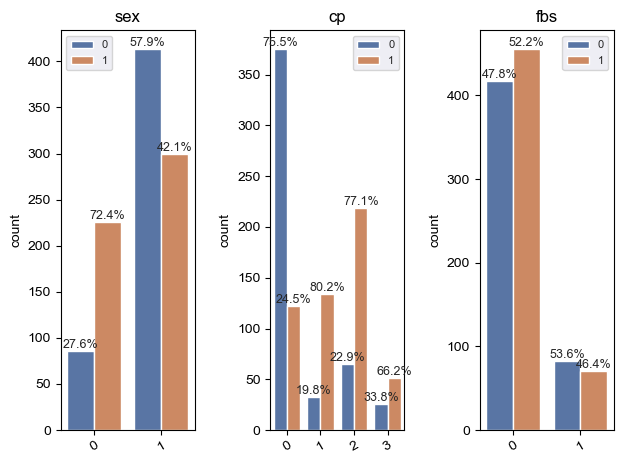

In [15]:
fig, axes = plt.subplots(1, 3)
sns.set(rc={'figure.figsize':(10, 4)})

for name, ax in zip(Categorical_vars_w_target[:3], axes.flatten()):
    plot = sns.countplot(x=name, data=df, hue="target", ax=ax)
    plot.set(title=name, xlabel=None)
    plot.legend(fontsize=8)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
    percentage_above_bar_relative_to_xgroup(plot, 9)
    
plt.tight_layout()

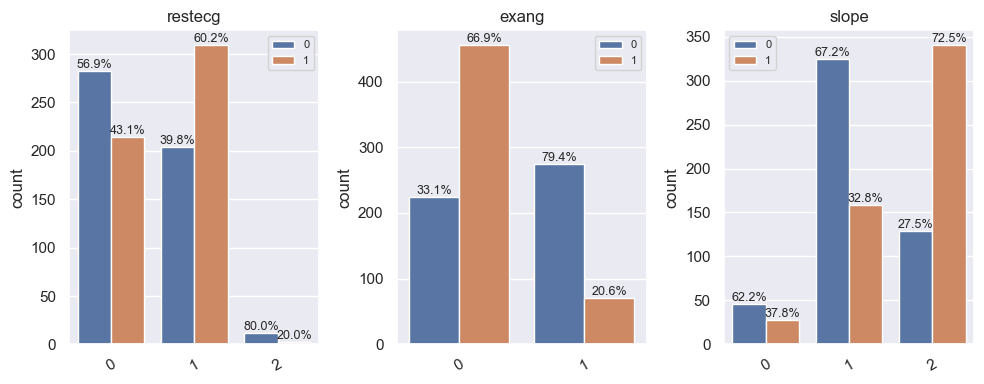

In [16]:
fig, axes = plt.subplots(1, 3)
sns.set(rc={'figure.figsize':(10, 4)})

for name, ax in zip(Categorical_vars_w_target[3:6], axes.flatten()):
    plot = sns.countplot(x=name, data=df, hue="target", ax=ax)
    plot.set(title=name, xlabel=None)
    plot.legend(fontsize=8)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
    percentage_above_bar_relative_to_xgroup(plot, 9)
    
plt.tight_layout()

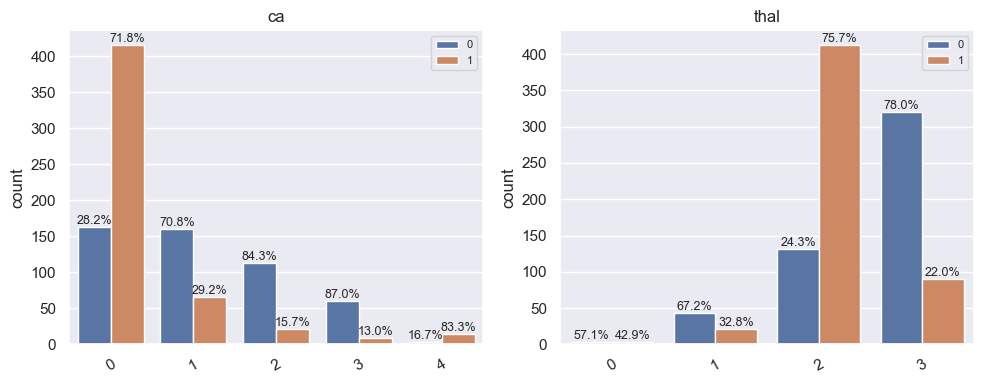

In [17]:
fig, axes = plt.subplots(1, 2)
sns.set(rc={'figure.figsize':(10, 4)})

for name, ax in zip(Categorical_vars_w_target[6:-1], axes.flatten()):
    plot = sns.countplot(x=name, data=df, hue="target", ax=ax)
    plot.set(title=name, xlabel=None)
    plot.legend(fontsize=8)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
    percentage_above_bar_relative_to_xgroup(plot, 9)
    
plt.tight_layout()

# Split the data into training and testing splits

In [18]:
# Get_dummies on df
data_w_dummies = pd.get_dummies(data=df, columns=Categorical_vars)

# Get the features and target variable from the dataframe
X = data_w_dummies.to_numpy()
y = data_w_dummies['target'].to_numpy()

# Split into training and testing parts
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    shuffle=True, 
                                                    random_state=42)

# Logistic Regression

We set the regularization parameter as 0.001 to get relatively bad scores. This is an example only to get metric scores that are not perfect.

In [19]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Use plain logreg with l2 regularization
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=.001,
                         penalty="l2", 
                         max_iter=10000)

# Pipeline object
from sklearn.pipeline import Pipeline
LogReg_model = Pipeline([('standard_scaler', scaler),
                             ('logistic_regression',lr)])

# Use cross-validate
from sklearn.model_selection import cross_validate
scores = cross_validate(LogReg_model, 
                        X_train, y_train, 
                        cv=5,
                         scoring=['accuracy','precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

In [20]:
metrics_df = pd.DataFrame()
metrics_df['accuracy_avg'] = [scores['test_accuracy'].mean()]
metrics_df['accuracy_std'] = [scores['test_accuracy'].std()]
metrics_df['precision_avg'] = [scores['test_precision'].mean()]
metrics_df['precision_std'] = [scores['test_precision'].std()]
metrics_df['recall_avg'] = [scores['test_recall'].mean()]
metrics_df['recall_std'] = [scores['test_recall'].std()]
metrics_df['f1_avg'] = [scores['test_f1'].mean()]
metrics_df['f1_std'] = [scores['test_f1'].std()]
metrics_df['roc_avg'] = [scores['test_roc_auc'].mean()]
metrics_df['roc_std'] = [scores['test_roc_auc'].std()]
metrics_df

,accuracy_avg,accuracy_std,precision_avg,precision_std,recall_avg,recall_std,f1_avg,f1_std,roc_avg,roc_std
0,0.929683,0.016195,0.906529,0.019956,0.965062,0.009421,0.934836,0.014745,0.98317,0.00641


# Model evaluation

##### Confusion matrix

In [21]:
LogReg_model.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=0.001, max_iter=10000))])

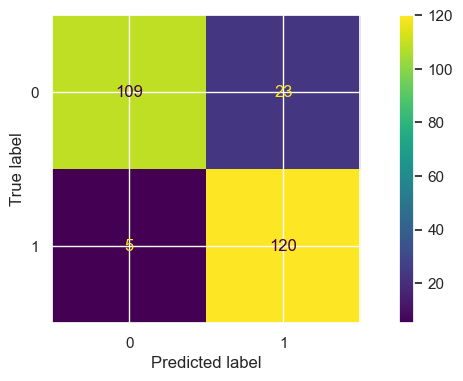

In [22]:
plt_confusion_matrix(LogReg_model, X_test, y_test)

# ROC-AUC Curve from Scratch

Since we are only changing the decision threshold, we do not need to retrain another LogReg model.

##### Probability of an example of belonging to class 1

In [23]:
probas = LogReg_model.predict_proba(X_test)
proba_that_sample_is_Heart_failure = probas[:,1]
proba_that_sample_is_Heart_failure

array([0.74658784, 0.67163426, 0.2255934 , 0.79449645, 0.29295968,
       0.61647753, 0.2864615 , 0.19131127, 0.69275683, 0.29838737,
       0.73971499, 0.25781018, 0.76633146, 0.61574224, 0.23123557,
       0.56395175, 0.21276453, 0.79432648, 0.65927592, 0.22486601,
       0.64834198, 0.29729064, 0.52939142, 0.21194717, 0.64834198,
       0.77514072, 0.78668738, 0.75677864, 0.25611868, 0.60325724,
       0.38662505, 0.68175378, 0.53156521, 0.67163426, 0.71734454,
       0.66131876, 0.64834198, 0.57910511, 0.64108283, 0.77845873,
       0.19131127, 0.29085184, 0.58458732, 0.52939142, 0.25748748,
       0.25212782, 0.36605039, 0.40864188, 0.50844336, 0.58525983,
       0.66667903, 0.1879081 , 0.55524247, 0.29777465, 0.78668738,
       0.64108283, 0.37840742, 0.19983101, 0.54557057, 0.73636452,
       0.70934906, 0.5869535 , 0.25611868, 0.58525983, 0.19959221,
       0.37598492, 0.83114081, 0.32739836, 0.25212782, 0.78233552,
       0.48798126, 0.25611868, 0.39952291, 0.76201564, 0.59962

In [24]:
from sklearn.metrics import recall_score

TPR_list = [] #also the recall
FPR_list = [] # 1 - TPR
for thresh in np.linspace(.1, 1, 100):
    y_pred_thresh = np.array([1 if i>=thresh else 0 for i in proba_that_sample_is_Heart_failure])
    
    recall = recall_score(y_test, y_pred_thresh)
    TPR_list.append(recall)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    FPR_list.append(fp / (tn+fp))

##### Plot

Text(0, 0.5, 'TPR')

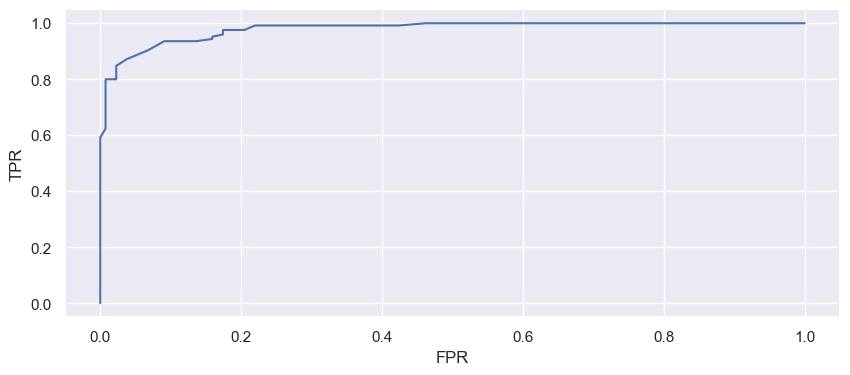

In [25]:
plt.figure()
plt.plot(FPR_list, TPR_list)
plt.xlabel('FPR')
plt.ylabel('TPR')

# Precision-Recall curve from scratch

In [26]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

recall_list = []
precision_list = []
for thresh in np.linspace(.3, .82, 100):
    y_pred_thresh = np.array([1 if i>=thresh else 0 for i in proba_that_sample_is_Heart_failure])
    
    recall_list.append(recall_score(y_test, y_pred_thresh))
    precision_list.append(precision_score(y_test, y_pred_thresh))

Text(0, 0.5, 'precision')

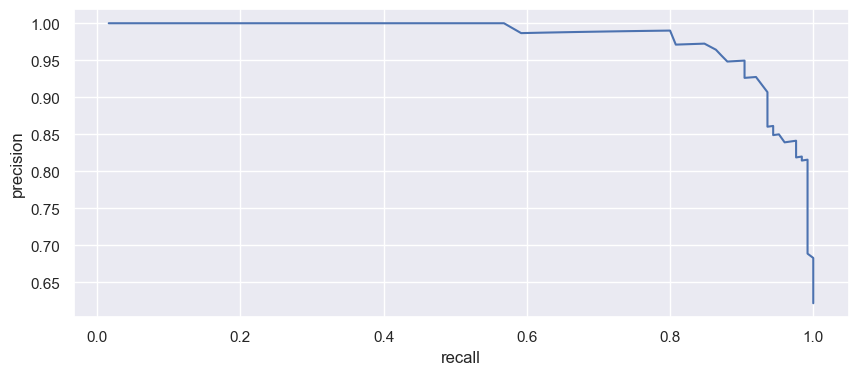

In [27]:
plt.figure()
plt.plot(recall_list, precision_list)
plt.xlabel('recall')
plt.ylabel('precision')

# ROC-AUC Curve using Sklearn

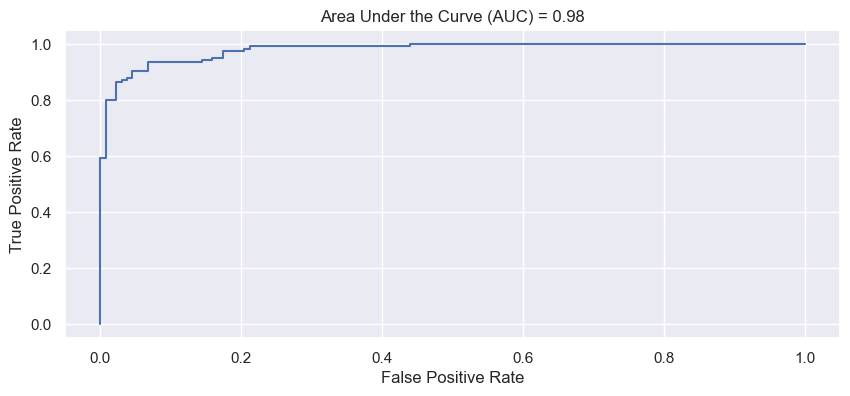

In [28]:
# Probability of a sample of being in class 1
y_pred_proba = LogReg_model.predict_proba(X_test)[:,1]

# Compute the FPR and TPR
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
FPR, TPR, thresholds = roc_curve(y_test, y_pred_proba)

#create ROC curve
plt.plot(FPR, TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Area Under the Curve (AUC) = {}'.format(round(roc_auc_score(y_test, LogReg_model.predict_proba(X_test)[:, 1]),2)))
plt.show()

Again, overall this is a good classifier.

##### Best probability threshold

In [29]:
optimal_idx = np.argmax(TPR - FPR)
optimal_threshold = thresholds[optimal_idx]
print('Best threshold according to the ROC curve: {}'.format(optimal_threshold))

Best threshold according to the ROC curve: 0.5465573634517441


In [30]:
print('Best point: ({}, {})'.format(FPR[optimal_idx], TPR[optimal_idx]))

Best point: (0.06818181818181818, 0.936)


# Precision-Recall Curve Using Sklearn

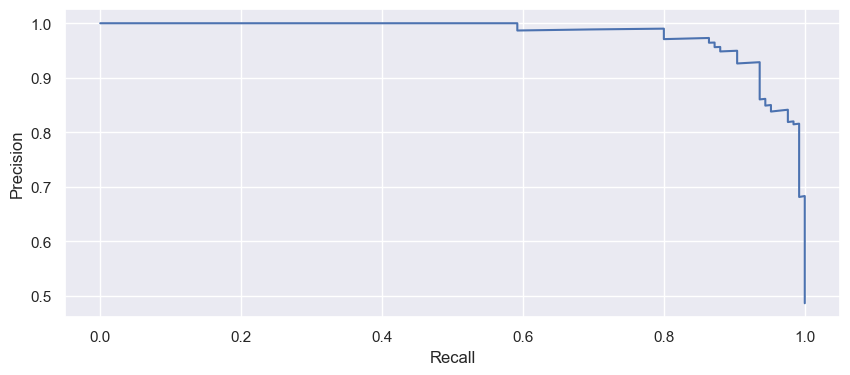

In [31]:
# Probability of a sample of being in class 1
y_pred_proba = LogReg_model.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds  = precision_recall_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

This looks like a good classifier.